# Read and Prepare the Data

In [1]:
# Common imports
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

np.random.seed(42)

In [2]:
#We will predict the "BAD" value in the data set:

loan = pd.read_csv("loan.csv")
loan.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,25900,61064.0,94714.0,DebtCon,Office,2.0,0.0,0.0,98.809375,0.0,23.0,34.565944
1,0,26100,113266.0,182082.0,DebtCon,Sales,18.0,0.0,0.0,304.852469,1.0,31.0,33.193949
2,1,50000,220528.0,300900.0,HomeImp,Self,5.0,0.0,0.0,0.000000,0.0,2.0,NaN
3,1,22400,51470.0,68139.0,DebtCon,Mgr,9.0,0.0,0.0,31.168696,2.0,8.0,37.952180
4,0,20900,62615.0,87904.0,DebtCon,Office,5.0,NaN,NaN,177.864849,NaN,15.0,36.831076


In [3]:
#Creating Test,Train Split
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(loan, test_size=0.3)

In [4]:
#Checking for NA values
train_set.isna().sum()
test_set.isna().sum()

BAD          0
LOAN         0
MORTDUE     71
VALUE       30
REASON      30
JOB         32
YOJ         60
DEROG       76
DELINQ      61
CLAGE       41
NINQ        59
CLNO        29
DEBTINC    262
dtype: int64

In [5]:
#Data Prep imports
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

In [6]:
#Seperating Y variable
train_y = train_set['BAD']
test_y = test_set['BAD']

train_inputs = train_set.drop(['BAD'], axis=1)
test_inputs = test_set.drop(['BAD'], axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8f51839820>,
      dtype=object)

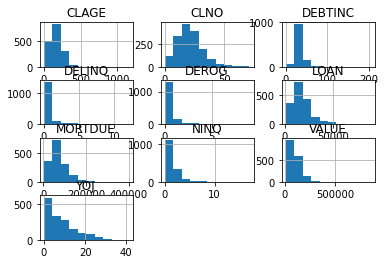

In [7]:
#CHecking histogram of all input variables
train_inputs.hist()

In [8]:
def new_col(df):
    df1 = df.copy()
    df1['VALUE_log'] =  np.log10(df1['VALUE'])
    return df1[['VALUE_log']]

In [9]:
train_inputs.dtypes

LOAN         int64
MORTDUE    float64
VALUE      float64
REASON      object
JOB         object
YOJ        float64
DEROG      float64
DELINQ     float64
CLAGE      float64
NINQ       float64
CLNO       float64
DEBTINC    float64
dtype: object

In [10]:
# Identifying the numerical columns
numeric_columns = train_inputs.select_dtypes(include=[np.number]).columns.to_list()

# Identifying the categorical columns
categorical_columns = train_inputs.select_dtypes('object').columns.to_list()

In [11]:
# Identifying the binary columns so we can pass them through without transforming
binary_columns = []

In [12]:
# Removing the binary columns from numerical columns.

for col in binary_columns:
    numeric_columns.remove(col)

In [13]:
binary_columns

[]

In [14]:
numeric_columns

['LOAN',
 'MORTDUE',
 'VALUE',
 'YOJ',
 'DEROG',
 'DELINQ',
 'CLAGE',
 'NINQ',
 'CLNO',
 'DEBTINC']

In [15]:
categorical_columns

['REASON', 'JOB']

In [16]:
transformed_columns = ['VALUE']

In [17]:
numeric_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [18]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [19]:
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

In [20]:
my_new_column = Pipeline(steps=[('my_new_column', FunctionTransformer(new_col)),
                               ('imputer', SimpleImputer(strategy='median')),
                               ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [21]:
preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns),
        ('binary', binary_transformer, binary_columns),
        ('trans', my_new_column, transformed_columns)],
        remainder='passthrough')


In [22]:
#Fit and transform the train data
train_x = preprocessor.fit_transform(train_inputs)

train_x

<1750x1586 sparse matrix of type '<class 'numpy.float64'>'
	with 22750 stored elements in Compressed Sparse Row format>

In [23]:
train_x.shape

(1750, 1586)

In [24]:
# Transform the test data
test_x = preprocessor.transform(test_inputs)

test_x

<750x1586 sparse matrix of type '<class 'numpy.float64'>'
	with 9115 stored elements in Compressed Sparse Row format>

In [25]:
test_x.shape

(750, 1586)

# Baseline:

In [26]:
train_y.value_counts()/len(train_y)

0    0.603429
1    0.396571
Name: BAD, dtype: float64

# Neural Network Model 1

In [27]:
from sklearn.neural_network import MLPClassifier

#Default settings create 1 hidden layer with 100 neurons
mlp_clf = MLPClassifier(max_iter=1000, verbose=False,
                        hidden_layer_sizes=(50,50,10))

mlp_clf.fit(train_x, train_y)

MLPClassifier(hidden_layer_sizes=(50, 50, 10), max_iter=1000)

In [28]:
#Predicting the train values
train_y_pred = mlp_clf.predict(train_x)

#Train accuracy
accuracy_score(train_y, train_y_pred)

1.0

In [29]:
#Predicting the test values
test_y_pred = mlp_clf.predict(test_x)

#Test accuracy
accuracy_score(test_y, test_y_pred)

0.76

# Neural Network Model 2

In [118]:
dnn_clf = MLPClassifier(hidden_layer_sizes=(50,30),
                       max_iter=2500, activation = 'tanh', solver='sgd',
                        learning_rate_init=0.3, early_stopping=True,validation_fraction=0.20)

dnn_clf.fit(train_x, train_y)



MLPClassifier(activation='tanh', early_stopping=True,
              hidden_layer_sizes=(50, 30), learning_rate_init=0.3,
              max_iter=2500, solver='sgd', validation_fraction=0.2)

In [119]:
#Let's check the number of iterations:
dnn_clf.n_iter_

28

In [120]:
#Predicting the train values
train_y_pred = dnn_clf.predict(train_x)

#Train accuracy
accuracy_score(train_y, train_y_pred)

0.9302857142857143

In [121]:
#Predicting the test values
test_y_pred = dnn_clf.predict(test_x)

#Test accuracy
accuracy_score(test_y, test_y_pred)

0.7813333333333333